# Required libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterstats
import math
import rasterio
import pandas as pd
from rasterio.mask import mask
from rasterio.fill import fillnodata
from rasterio.transform import from_origin
from shapely import geometry as sg
from shapely.geometry import LineString, MultiLineString, Polygon, MultiPolygon
from scipy.interpolate import griddata
import geohexgrid as ghg  

# Script 


## Function definitions

In [53]:
# Calculate longitudinal and transverse projections of Minimum bounding boxes (MBBs)
def calculate_projections(mbb_geometry, local_angle_deg):
    """
    Calculate longitudinal and transverse projections of MBBs based on local angles.
    """
    coords = list(mbb_geometry.exterior.coords)[:-1]
    vectors = [np.array(coords[i+1]) - np.array(coords[i]) for i in range(len(coords) - 1)]
    lengths = [np.linalg.norm(v) for v in vectors]
    long_vector, short_vector = vectors[np.argmax(lengths)], vectors[np.argmin(lengths)]

    # Rotation vectors based on local angle
    theta_flux = np.radians(90 - local_angle_deg)
    u = np.array([np.cos(theta_flux), np.sin(theta_flux)])
    v = np.array([-np.sin(theta_flux), np.cos(theta_flux)])    

    return {
        "max_longitudinal": max(np.abs(np.dot(long_vector, u)), np.abs(np.dot(short_vector, u))),
        "max_transverse": max(np.abs(np.dot(long_vector, v)), np.abs(np.dot(short_vector, v)))
    }


##############################################################################################################


def calculate_isin(geometry):
    """
    Compute the sinuosity index (Isin).
    """
    if isinstance(geometry, LineString):
        curvilinear_length = geometry.length
        straight_length = LineString([geometry.coords[0], geometry.coords[-1]]).length
    elif isinstance(geometry, MultiLineString):
        curvilinear_length = sum(line.length for line in geometry.geoms)
        straight_length = LineString([geometry.geoms[0].coords[0], geometry.geoms[-1].coords[-1]]).length
    else:
        return np.nan

    if curvilinear_length == 0 or straight_length == 0:
        return np.nan

    return ((curvilinear_length / straight_length) - 1) / (math.sqrt(5) - 1)

## Paths for input and output files

### Input paths

In [63]:
outlines = gpd.read_file(r'smoothed_outlines.gpkg') # Load polygons from a GeoPackage
 
Input_DEM = r'input_dem.tif'  # Input topographic data

centerlines = r'smoothed_centerlines.gpkg' # Path to centerlines (lines)

flux = r'flux.gpkg' # Path to flux vectors (lines with an 'angle' attribute, containing angles values between 0 and 360° north) 


### Ouput paths

In [64]:
outline_output_path = r'outlines_with_morphometrics.gpkg'  # Outlines with morphometric parameter values
grid_output_path = r'hexagonal_grid_with_morphometrics.gpkg'  # Hexagonal grid with morphometric parameter values


## Variables

In [65]:
resolution = 10  # Spatial resolution of the raster
threshold = 1000  # Minimum area threshold for filtering small bedforms (in m²)
R = 1500  # Size for the hexagons (in meters)
min_outlines = 0  # Set a minimum threshold for the number of outlines per hexagon

## Morphometric parameters computation

### Opening topographic data file and area related parameters :
### (Area, Volume, Equivalent thickness) 

In [66]:
# Open the DEM and read the raster data
with rasterio.open(Input_DEM) as src:
    topo = src.read(1)
    profile = src.profile

# Calculate the area of each bedform
outlines['area'] = outlines.geometry.area

# Filter outlines by area (remove small ones below the threshold)
outlines = outlines[outlines['area'] > threshold].reset_index(drop=True)

# Reopen the DEM to use it for masking
with rasterio.open(Input_DEM) as src:
    # Mask the outlines, creating a raster with "holes"
    out_image, out_transform = mask(src, outlines.geometry, filled=True, invert=True)

# Fill the "holes" in the raster using interpolation
arr_filled = fillnodata(out_image, mask=out_image, max_search_distance=50, smoothing_iterations=0)

# Compute the elevation difference between the original raster and the filled raster
keewatin_bedforms_topo = topo - arr_filled

# Continue with the rest of your computations
stats = rasterstats.zonal_stats(outlines, keewatin_bedforms_topo[0, :, :], affine=out_transform, stats="mean sum std")
outlines['mean_elevation'] = [s['mean'] for s in stats]
outlines['sum_elevation'] = [s['sum'] for s in stats]
outlines['std_elevation'] = [s['std'] for s in stats]

# Calculate outlines volume and equivalent thickness
outlines['volume'] = outlines['sum_elevation'] * resolution**2
outlines['Equ_th'] = outlines['volume'] / outlines['area']



### Perimeter and circularity index calculation

In [67]:
outlines['perimeter'] = outlines.geometry.length
outlines['Icirc'] = (4 * outlines['area'] * math.pi) / (outlines['perimeter'] ** 2)

### Oriented elongation index calculation 

In [68]:

# Load flux lines (vectors) from GeoPackage
lines = gpd.read_file(flux)

# Extract centroid coordinates and angles
points_x1, points_y1 = lines.geometry.centroid.x, lines.geometry.centroid.y
angles1 = lines['angle']

# Convert angles to unit vectors (cosine and sine components)
cos_angles = np.cos(np.radians(angles1))
sin_angles = np.sin(np.radians(angles1))

# Define the extent of the main raster
with rasterio.open(Input_DEM) as src:
    xmin, ymin, xmax, ymax = src.bounds

# Create a grid for interpolation
grid_x, grid_y = np.linspace(xmin, xmax, 2000), np.linspace(ymin, ymax, 2000)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)
grid_points = np.vstack((grid_xx.ravel(), grid_yy.ravel())).T

# Interpolate cosine and sine components over the grid
z_cos = griddata((points_x1, points_y1), cos_angles, (grid_xx, grid_yy), method='nearest')
z_sin = griddata((points_x1, points_y1), sin_angles, (grid_xx, grid_yy), method='nearest')

# Compute interpolated angles from the cosine and sine components
interpolated_angles = np.degrees(np.arctan2(z_sin, z_cos)) % 360

# Save interpolated angles as a raster
transform = from_origin(xmin, ymax, (xmax - xmin) / grid_x.size, (ymax - ymin) / grid_y.size)



# Compute Minimum Bounding Boxes (rotated rectangles) for each bedform
outlines['MBB'] = outlines.geometry.apply(lambda geom: geom.minimum_rotated_rectangle)


# Interpolate local flux angles at MBB centroids
mbb_centroids_x, mbb_centroids_y = outlines.geometry.centroid.x, outlines.geometry.centroid.y
local_cos = griddata(grid_points, z_cos.ravel(), (mbb_centroids_x, mbb_centroids_y), method='nearest')
local_sin = griddata(grid_points, z_sin.ravel(), (mbb_centroids_x, mbb_centroids_y), method='nearest')
local_angles_deg = (np.degrees(np.arctan2(local_sin, local_cos)) + 360) % 360

# Compute projections for each MBB
projections = outlines.apply(
    lambda row: calculate_projections(row['MBB'], local_angle_deg=local_angles_deg[row.name]), axis=1)
outlines['max_longitudinal'] = [p['max_longitudinal'] for p in projections]
outlines['max_transverse'] = [p['max_transverse'] for p in projections]
outlines['Ieo'] = np.log10(outlines['max_longitudinal'] / outlines['max_transverse'])

### Sinuosity index calculation

In [69]:
# Apply sinuosity computation to centerlines
centerlines = gpd.read_file(centerlines)
centerlines['Isin'] = centerlines.geometry.apply(calculate_isin)

# Join Isin values to bedforms
outlines = gpd.sjoin(outlines, centerlines[['geometry', 'Isin']], how='left', predicate='intersects')


### Degree of Evolution calculation

In [70]:
outlines['Evodeg'] = (np.pi/2 + np.arctan(outlines['Ieo']/outlines['Isin'])) * (outlines['Ieo'] + 1)

### Outlines with morphometrics export

In [71]:
# Save final bedform parameters
outlines[['geometry', 'area', 'perimeter', 'mean_elevation', 'sum_elevation', 'std_elevation',
          'volume', 'Equ_th', 'Icirc', 'Isin', 'Ieo', 'Evodeg']].to_file(outline_output_path, driver="GPKG")
print(f"outlines with morphometrics saved to {outline_output_path}")

outlines with morphometrics saved to outlines_with_morphometrics.gpkg


## Hexagonal grid generation and statistical sampling


### Grid generation

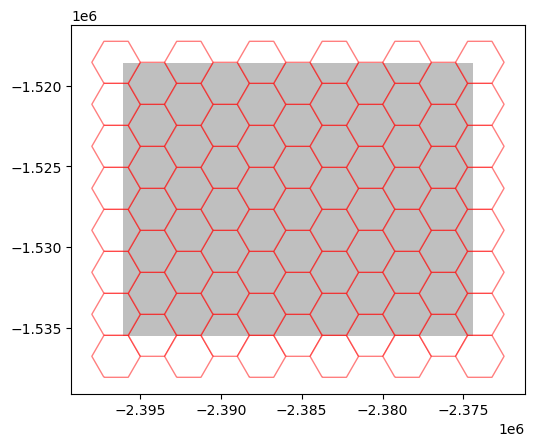

In [72]:


# Open the main raster file to extract its spatial bounds
with rasterio.open(Input_DEM) as src:
    xmin, ymin, xmax, ymax = src.bounds  # Get raster bounds (min/max coordinates)

# Expand the raster bounds slightly to ensure full coverage
buffer = 2 * R  # Adjust the buffer based on the hexagon size (circumcircle radius)
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Define a rectangular region using the expanded bounds
region = gpd.GeoDataFrame(geometry=[sg.Polygon([
    (xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)
])])

# Generate the hexagonal grid based on the bounds of the region
grid = ghg.make_grid_from_bounds(*region.total_bounds, R=R)

# -------------------------------------------
# Center the hexagonal grid on the region
# -------------------------------------------

# Calculate the center of the rectangular region
region_center_x = (xmin + xmax) / 2
region_center_y = (ymin + ymax) / 2

# Calculate the center of the generated hexagonal grid
grid_center_x = grid.geometry.unary_union.centroid.x
grid_center_y = grid.geometry.unary_union.centroid.y

# Compute the offset needed to align the grid's center with the region's center
offset_x = region_center_x - grid_center_x
offset_y = region_center_y - grid_center_y

# Translate the hexagonal grid by the computed offset
grid_translated = grid.translate(xoff=offset_x, yoff=offset_y)

# Merge the region's geometry into a single polygon
region_polygon = region.geometry.unary_union

# Keep only hexagons that intersect the original region polygon
grid_translated = grid_translated[grid_translated.geometry.intersects(region_polygon)]

# Plot the rectangular region as a base layer
base = region.plot(color='gray', aspect="equal")

# Overlay the translated hexagonal grid with semi-transparent styling
grid_translated.plot(ax=base, color="white", edgecolor="red", alpha=0.5)

# Show the plot with the region and hexagonal grid
plt.show()






### Statistic sampling on the hexagonal grid

In [73]:

# List of parameters to sample
parametres = [
    'area', 'perimeter', 'mean_elevation', 'sum_elevation', 'std_elevation',
    'volume', 'Equ_th', 'Icirc', 'Isin', 'Ieo', 'Evodeg']

# Convert the hexagonal grid into a GeoDataFrame
grid_translated_gdf = gpd.GeoDataFrame(geometry=grid_translated, crs=outlines.crs)

# Find intersections between bedforms and hexagons using spatial join
# - `how='inner'` ensures we only keep overlapping features
# - `predicate='intersects'` matches geometries that intersect
intersections = gpd.sjoin(
    outlines,
    grid_translated_gdf,
    how='inner',
    predicate='intersects',
    lsuffix='outline',
    rsuffix='grid'
)
# Compute the median of each parameter for outlines within each hexagon
medians = intersections.groupby('index_right')[parametres].median()

# Count the number of outlines overlapping each hexagon
outlines_counts = intersections.groupby('index_right').size()

# Join the computed medians back to the hexagonal grid GeoDataFrame
hexagons = grid_translated_gdf.join(medians, how='left')

# Add the bedform count as a new column in the hexagonal grid
hexagons['outlines_count'] = outlines_counts

# Keep only hexagons with a bedform count greater than or equal to the threshold
filtered_hexagons = hexagons[hexagons['outlines_count'] >= min_outlines]




### Hexagonal grid with morphometric parameters export 

In [75]:

# Save the filtered hexagons and their parameters to a new GeoPackage file
filtered_hexagons[
    ['geometry', 'area', 'perimeter', 'mean_elevation', 'sum_elevation', 'std_elevation',
     'volume', 'Equ_th', 'Icirc', 'Isin', 'Ieo', 'Evodeg', 'outlines_count']
].to_file(grid_output_path, driver='GPKG')

# Print the first few rows of the filtered hexagons for validation
print(filtered_hexagons.head())

                                              geometry           area  \
0.0  POLYGON ((-2397235.00000 -1538042.77671, -2395...    1222.532409   
3.0  POLYGON ((-2390485.00000 -1536743.73861, -2388...  140960.855534   
4.0  POLYGON ((-2388235.00000 -1538042.77671, -2386...    1267.305147   
5.0  POLYGON ((-2385985.00000 -1536743.73861, -2384...    4922.018407   
6.0  POLYGON ((-2383735.00000 -1538042.77671, -2382...    1846.150536   

       perimeter  mean_elevation  sum_elevation  std_elevation        volume  \
0.0   145.068225        0.109874       1.208611       0.044886    120.861053   
3.0  3499.757704        0.316049     444.049072       0.371759  44404.907227   
4.0   149.594552        0.135397       1.624763       0.082510    162.476349   
5.0   317.202426        0.104344       5.217194       0.117080    521.719360   
6.0   211.266979        0.059199       1.065575       0.024174    106.557465   

       Equ_th     Icirc      Isin       Ieo    Evodeg  outlines_count  
0.0  0.0